# FINAL PROJECT: tourism in Europe

In [2]:
# 1. Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, pearsonr

In [3]:
# Make plots prettier

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

In [51]:
# 2. Load dataset

df = pd.read_csv("../data/clean/airbnb_clean.csv")
df_eurostat = pd.read_csv("../data/clean/FROM SQL/eurostat_world_data.csv")

In [5]:
# 3. Dataset overview

print("Shape of dataset:", df.shape)

print("\nMissing values per column:")
print(df.isna().sum())

print("\nData types:")
print(df.dtypes)

print("\nSummary statistics (numerical features):")
print(df.describe())

Shape of dataset: (114213, 17)

Missing values per column:
listing_name                 44
neighbourhood_cleansed        0
latitude                      0
longitude                     0
room_type                     0
accommodates                  0
bedrooms                    248
beds                        177
bathrooms                    48
bathrooms_text               98
price                         0
minimum_nights                0
maximum_nights                0
availability_365              0
number_of_reviews             0
review_scores_rating      21667
city                          0
dtype: int64

Data types:
listing_name               object
neighbourhood_cleansed     object
latitude                  float64
longitude                 float64
room_type                  object
accommodates                int64
bedrooms                  float64
beds                      float64
bathrooms                 float64
bathrooms_text             object
price                     float

## H1: Room type influence price

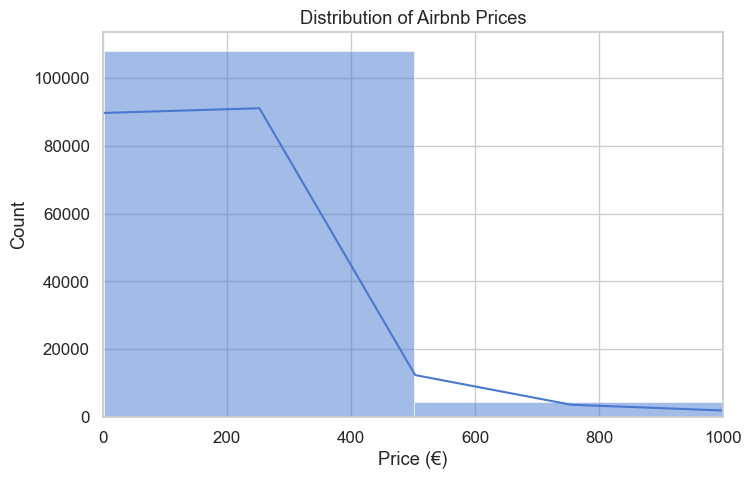

In [7]:
# 4. Distribution of prices

plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=100, kde=True)
plt.xlim(0, 1000)  # limit axis for readability
plt.title("Distribution of Airbnb Prices")
plt.xlabel("Price (€)")
plt.ylabel("Count")
plt.show()

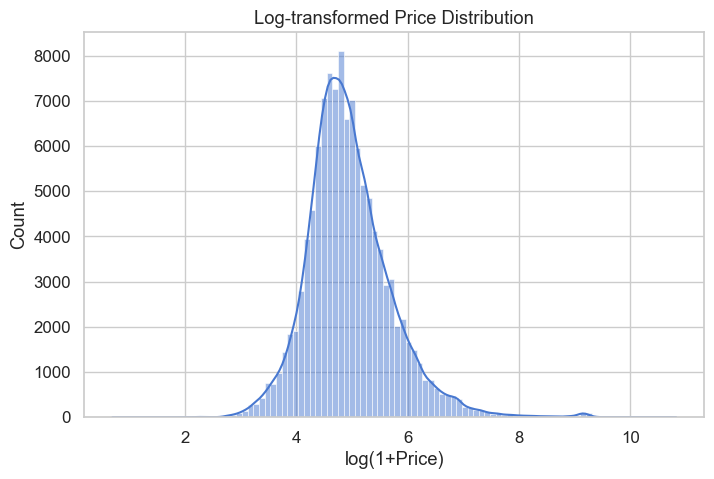

In [8]:
# Log-transformed price
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(df['price']), bins=100, kde=True)
plt.title("Log-transformed Price Distribution")
plt.xlabel("log(1+Price)")
plt.ylabel("Count")
plt.show()

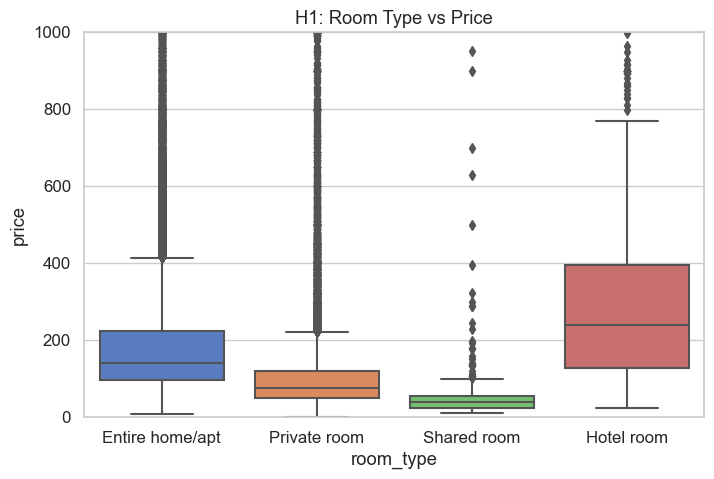

In [9]:
# 5. Hypothesis testing

## Hypothesis 1: Room type influences price
plt.figure(figsize=(8,5))
sns.boxplot(x="room_type", y="price", data=df)
plt.ylim(0, 1000)  # cut at 1000 for clarity
plt.title("H1: Room Type vs Price")
plt.show()

In [10]:
# Statistical test: ANOVA
groups = [df[df["room_type"]==rt]["price"].dropna() for rt in df["room_type"].unique()]
anova_test = f_oneway(*groups)
print("ANOVA test (room_type vs price):")
print("F-statistic:", anova_test.statistic)
print("p-value:", anova_test.pvalue)


ANOVA test (room_type vs price):
F-statistic: 451.1194460271183
p-value: 2.0651529850573897e-291


/var/folders/7w/mr3l1rjn21bd3r_kvq3bgr1h0000gn/T/ipykernel_12789/1128554688.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x="room_type", y="price", data=df, estimator=np.mean, ci=None, palette="Set2")


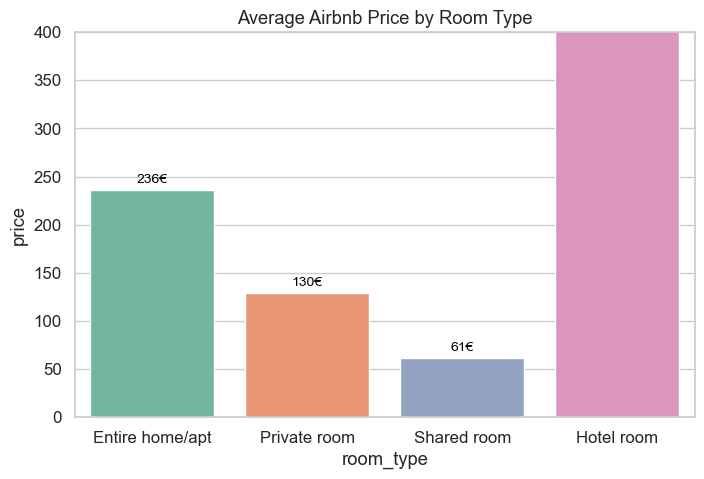

In [11]:
# Average price per room type
avg_price_by_room = df.groupby("room_type")["price"].mean().sort_values()

plt.figure(figsize=(8,5))
ax = sns.barplot(x="room_type", y="price", data=df, estimator=np.mean, ci=None, palette="Set2")
plt.ylim(0, 400)
plt.title("Average Airbnb Price by Room Type")

# Add value labels on bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}€",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", va="bottom", fontsize=10, color="black", xytext=(0, 3),
                textcoords="offset points")

plt.show()

## H2: Capacity vs Price per person

In [13]:
df["price_per_person"] = df["price"] / df["accommodates"]

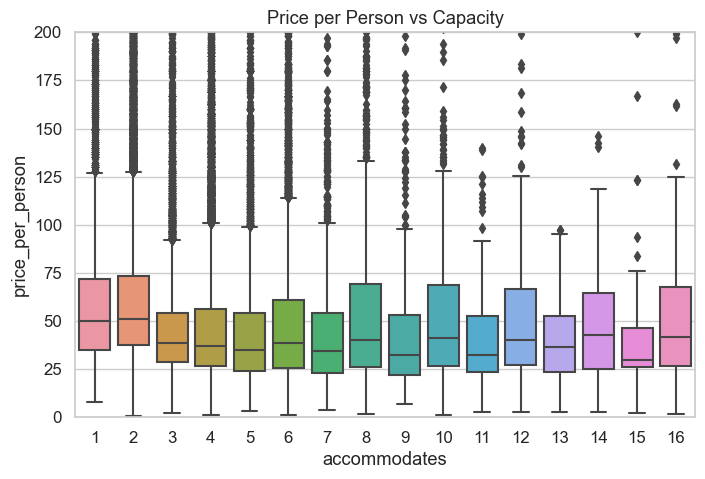

In [14]:
# Boxplot price per person vs accommodates
plt.figure(figsize=(8,5))
sns.boxplot(x="accommodates", y="price_per_person", data=df)
plt.ylim(0, 200)  # limit axis for readability
plt.title("Price per Person vs Capacity")
plt.show()

In [15]:
corr_pp, p_val_pp = pearsonr(df["accommodates"].dropna(), df["price_per_person"].dropna())
print("Correlation (capacity vs price per person):", corr_pp)
print("p-value:", p_val_pp)

if corr_pp < 0 and p_val_pp < 0.05:
    print("Hypothesis supported: More capacity,’ lower price per person.")
else:
    print("Hypothesis not supported.")

Correlation (capacity vs price per person): -0.0232504343432861
p-value: 3.885846994919968e-15
Hypothesis supported: More capacity,’ lower price per person.


## H3: The city has a significant influence on Airbnb prices

/var/folders/7w/mr3l1rjn21bd3r_kvq3bgr1h0000gn/T/ipykernel_12789/3574791468.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x="city", y="price", data=df, estimator=np.mean, ci=None, palette="Set2")


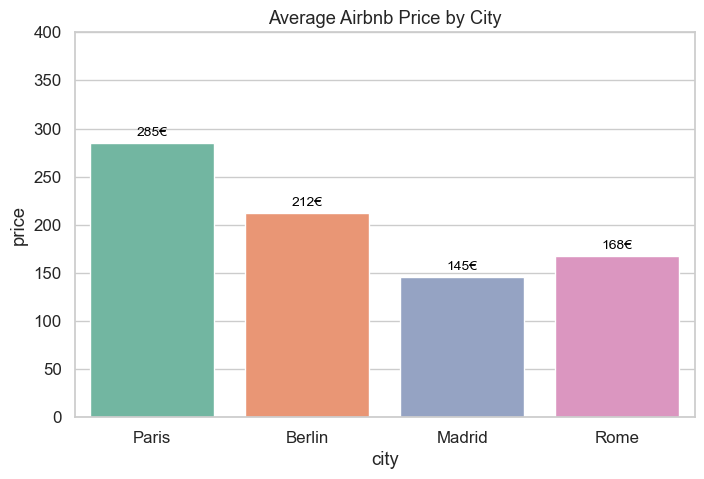

In [17]:
plt.figure(figsize=(8,5))
ax = sns.barplot(x="city", y="price", data=df, estimator=np.mean, ci=None, palette="Set2")
plt.ylim(0, 400)
plt.title("Average Airbnb Price by City")

# Add labels on bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}€",
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha="center", va="bottom", fontsize=10, color="black", xytext=(0, 3),
                textcoords="offset points")
plt.show()

In [18]:
groups_city = [df[df["city"]==c]["price"].dropna() for c in df["city"].unique()]
anova_city = f_oneway(*groups_city)

print("ANOVA test (city vs price):")
print("F-statistic:", anova_city.statistic)
print("p-value:", anova_city.pvalue)

if anova_city.pvalue < 0.05:
    print("Hypothesis supported: City significantly influences price.")
else:
    print("Hypothesis not supported.")

ANOVA test (city vs price):
F-statistic: 267.23132958043436
p-value: 7.5073552375435e-173
Hypothesis supported: City significantly influences price.


## H4: The rating score influences price

In [84]:
# 1. Drop missing values (many listings may not have reviews yet)

df_rating = df.dropna(subset=["review_scores_rating", "price"])

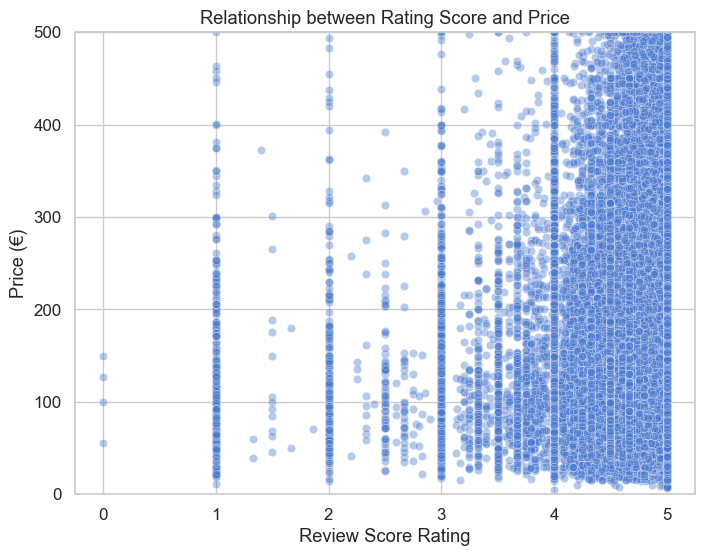

In [86]:
# 2. Scatter plot: Rating vs Price (limited y-axis for readability)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="review_scores_rating", 
    y="price", 
    data=df_rating, 
    alpha=0.4
)
plt.ylim(0, 500)  # limit axis to avoid extreme outliers
plt.title("Relationship between Rating Score and Price")
plt.xlabel("Review Score Rating")
plt.ylabel("Price (€)")
plt.show()

In [88]:
# 3. Correlation test (Pearson)

corr, p_value = pearsonr(df_rating["review_scores_rating"], df_rating["price"])
print("Correlation coefficient (r):", round(corr, 3))
print("p-value:", p_value)

Correlation coefficient (r): 0.0
p-value: 0.9024929227165044


## H5: Availability (days listed per year) influences price

In [94]:
# 1. Keep relevant columns

df_avail = df.dropna(subset=["availability_365", "price"])

In [96]:
# 2. Create a new category for availability

def availability_category(x):
    if x == 365:
        return "Full year"
    elif x > 180:
        return "More than half year"
    elif x > 30:
        return "1–6 months"
    else:
        return "Less than 1 month"

df_avail["availability_cat"] = df_avail["availability_365"].apply(availability_category)

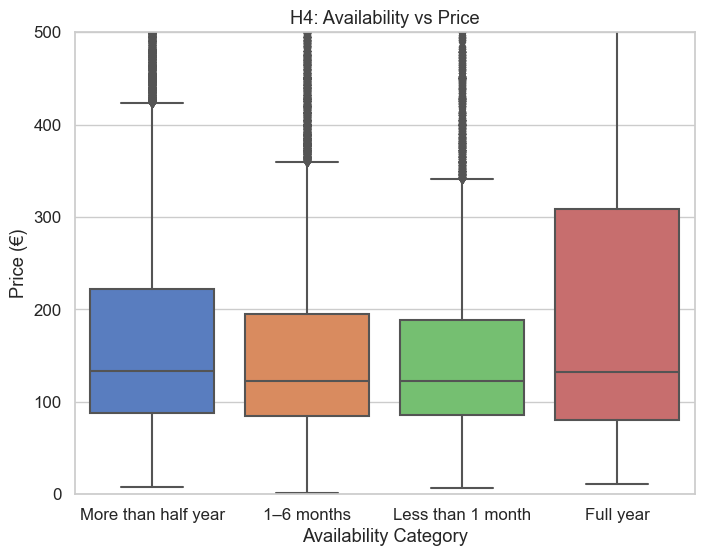

In [98]:
# 3. Boxplot: Price vs Availability category

plt.figure(figsize=(8,6))
sns.boxplot(x="availability_cat", y="price", data=df_avail)
plt.ylim(0, 500)  # limit for readability
plt.title("H4: Availability vs Price")
plt.xlabel("Availability Category")
plt.ylabel("Price (€)")
plt.show()

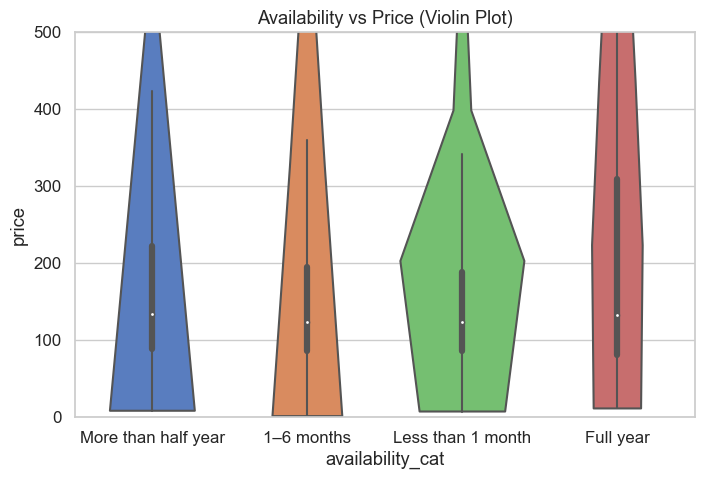

In [110]:
plt.figure(figsize=(8,5))
sns.violinplot(x="availability_cat", y="price", data=df_avail, cut=0)
plt.ylim(0, 500)  # pour enlever les valeurs extrêmes
plt.title("Availability vs Price (Violin Plot)")
plt.show()

/var/folders/7w/mr3l1rjn21bd3r_kvq3bgr1h0000gn/T/ipykernel_12789/1151757924.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x="availability_cat", y="price", data=df_avail, ci="sd")


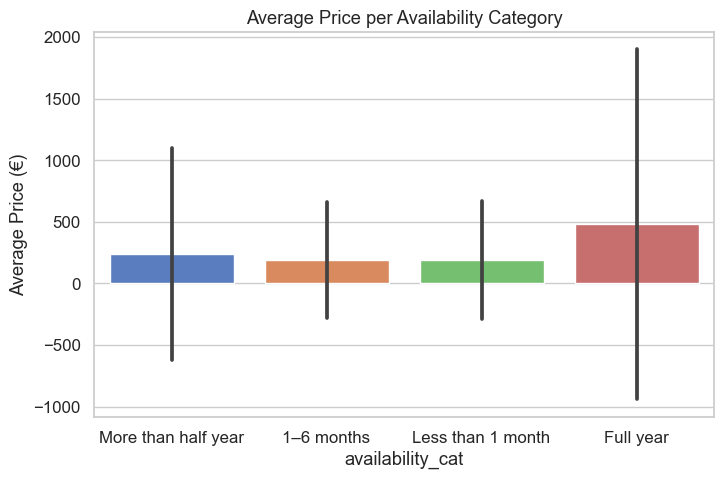

In [112]:
plt.figure(figsize=(8,5))
sns.barplot(x="availability_cat", y="price", data=df_avail, ci="sd")
plt.title("Average Price per Availability Category")
plt.ylabel("Average Price (€)")
plt.show()

In [114]:
# 4. ANOVA test between categories
groups = [
    df_avail[df_avail["availability_cat"] == cat]["price"]
    for cat in df_avail["availability_cat"].unique()
]

f_stat, p_value = f_oneway(*groups)
print("ANOVA test (availability vs price):")
print("F-statistic:", f_stat)
print("p-value:", p_value)

# 5. Correlation as an alternative check
corr, p_corr = pearsonr(df_avail["availability_365"], df_avail["price"])
print("\nCorrelation (availability_365 vs price):", round(corr, 3))
print("p-value:", p_corr)

ANOVA test (availability vs price):
F-statistic: 146.6613418225656
p-value: 7.346078098034065e-95

Correlation (availability_365 vs price): 0.049
p-value: 5.197974031065263e-62
